In [1]:
using SparseArrays
using LinearAlgebra
using Plots
using Statistics
using SuiteSparse
using FiniteDifferences
E0 = 1;
Emin = 1e-9;
nu = 0.3;

In [7]:
using FiniteDiff
FiniteDiff.finite_difference_jacobian

finite_difference_jacobian (generic function with 6 methods)

In [8]:
function topFD(nelx,nely,objectif ,volfrac = 0.4 ,penal = 3,rmin = 2.5 ,ft = 1)
        
    A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12]
    A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6]
    B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4]
    B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2]
    KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11])

    nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx); #number of the nodes in columns
    edofVec = reshape(2*nodenrs[1:end-1,1:end-1].+1,nelx*nely,1) ;#1st dof of each element (x top left)
    edofMat = zeros(nelx*nely, 8); #every line i contains the 8 dof of the ith element
    noeudsvoisins = [0 1 2*nely.+[2 3 0 1] -2 -1];
    for i = 1:8
        for j = 1:nelx*nely
            edofMat[j,i]= edofVec[j]+ noeudsvoisins[i] ;
        end
    end
    #maillage
    iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);# line to build  K
    jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);# columns
    #F = spzeros(2*(nely+1)*(nelx+1),1); F[2,1] = -1;   impossible to solve with F sparse in Julia
    F = zeros(2*(nely+1)*(nelx+1),1); F[2,1] = -1; 
    U = zeros(2*(nely+1)*(nelx+1),1);
    fixeddofs = union(1:2:2*(nely+1),[2*(nelx+1)*(nely+1)]);
    alldofs = 1:2*(nely+1)*(nelx+1);
    freedofs = setdiff(alldofs,fixeddofs);
    #filtering is linear + chain's rule -> matricial opration with operator H
    iH = ones(nelx*nely*(2*(convert(Int64,ceil(rmin)-1))+1)^2);#lines H
    jH = ones(size(iH));# columns
    sH = zeros(size(iH));# values
    k = 0;
    for i1 = 1:nelx
        for j1 = 1:nely
            e1 = (i1-1)*nely+j1;
            for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
                for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
                    e2 = (i2-1)*nely+j2;
                    k = k+1;
                    iH[k] = e1;
                    jH[k] = e2;
                    sH[k] = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
                end
            end
        end
    end
    H = sparse(iH,jH,sH);# matrix of the Hei
    Hs = [sum(H[i,:]) for i = 1:(size(H)[1])];# sum of the Hei for e fixed -> coeffs used to divide in the filter
    #variables
    x = volfrac*ones(nely,nelx);
    xPhys = x;#new variable for the density filter
    loop = 0;
    change = 1;
    cValues = []
    while change > 0.01
        loop = loop + 1;
        
        sK = [j*((i+Emin)^penal) for i in ((E0-Emin)*xPhys[:]') for j in KE[:] ];#new values EF
        K = sparse(iK[:],jK[:],sK); K = (K+K')/2;# force to be symmetric
        KK = cholesky(K[freedofs,freedofs]);
        U[freedofs] = KK\F[freedofs];
        
        # analyse, objective function 
        edM = [convert(Int64,i) for i in edofMat] ;#to index by int
        mat = (U[edM]*KE).*U[edM];
        ce = reshape([sum(mat[i,:]) for i = 1:(size(mat)[1])],nely,nelx);

        #new
        c = objectif(xPhys,ce) #sum(sum((Emin*ones(size(xPhys)).+(xPhys.^penal)*(E0-Emin)).*ce));
        push!(cValues,c)
        

        #dc = central_fdm(5,1)(x -> objectif(x,ce), xPhys) 
        dc = -FiniteDiff.finite_difference_gradient(x -> objectif(x,ce), xPhys)

        dv = ones(nely,nelx);
        
        #filtering : maybe other filters are needed if the objective function is not the sensitivity
        if ft == 1
            dc[:] = H*(x[:].*dc[:])./Hs./max(1e-3,maximum(x[:]));
        elseif ft == 2
            dc[:] = H*(dc[:]./Hs);
            dv[:] = H*(dv[:]./Hs);
        end
        #Lagrangian multiplicators research, upload of the density x
        l1 = 0; l2 = 1e9; move = 0.2;
        xnew = zeros(nely, nelx);
        while (l2-l1)/(l1+l2) > 1e-3
            lmid = 0.5*(l2+l1);
            RacBe = sqrt.(-dc./dv/lmid) ;
            XB = x.*RacBe ;
            for i = 1:nelx
                for j = 1:nely
                    xji = x[j,i];
                    xnew[j,i]= max(0.001,max(xji-move,min(1,min(xji+move,XB[j,i]))));
                end
            end  
            if ft == 1
                xPhys = xnew;
            elseif ft == 2 # if we chose the density filter
                xPhys[:] = (H*xnew[:])./Hs;
            end
            if sum(xPhys[:]) > volfrac*nelx*nely
                l1 = lmid;
            else 
                l2 = lmid; 
            end
        end
        change = maximum(abs.(x-xnew));
        x = xnew;
        println("loop = ", loop, "Change = ", change ," c = ", c , " densité struct = ", mean(x) )
        if loop == 25
            return heatmap(x), loop, cValues
        end
    end
    return heatmap(x ), loop , cValues
end

topFD (generic function with 5 methods)

loop = 1Change = 0.2 c = 240.55295821333357 densité struct = 0.49985205408529515
loop = 2Change = 0.20000000000000007 c = 142.29012811626535 densité struct = 0.49995425634059665
loop = 3Change = 0.20000000000000007 c = 101.2904274436662 densité struct = 0.5002055990426127
loop = 4Change = 0.20000000000000007 c = 80.66559466002106 densité struct = 0.5000701664445731
loop = 5Change = 0.20000000000000007 c = 70.50380077833101 densité struct = 0.4999593510384339
loop = 6Change = 0.20000000000000007 c = 62.76373410430314 densité struct = 0.5001263850754951
loop = 7Change = 0.20000000000000007 c = 57.56945696626541 densité struct = 0.5001217270840642
loop = 8Change = 0.20000000000000007 c = 53.32531773669797 densité struct = 0.49999885198096816
loop = 9Change = 0.20000000000000007 c = 50.25849153006335 densité struct = 0.5000234491491705
loop = 10Change = 0.20000000000000007 c = 48.810735379919066 densité struct = 0.4999699894660608
loop = 11Change = 0.20000000000000007 c = 48.1194088739407 

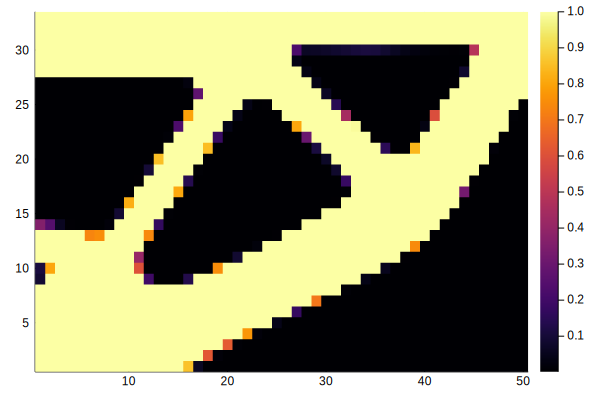

In [9]:
penal = 3
sensi( x, ce)= sum(sum((Emin*ones(size(x)).+(x.^penal)*(E0-Emin)).*ce));# example of the sensitivity to see if the results do match


x,l,values= topFD(100,100,sensi ,0.5,3,2)

x

In [11]:
values

25-element Array{Any,1}:
 240.55295821333357
 142.29012811626535
 101.2904274436662
  80.66559466002106
  70.50380077833101
  62.76373410430314
  57.56945696626541
  53.32531773669797
  50.25849153006335
  48.810735379919066
  48.1194088739407
  47.70674372180917
  47.47118108646299
  47.34348568960219
  47.23921451317546
  47.1279737927421
  46.99585047321044
  46.7967007201364
  46.53871601377493
  46.304486446611065
  46.234969316392935
  46.18414432816459
  46.137793947707465
  46.09535345946886
  46.05217117865928

In [13]:
@time x,l,values= topFD(100,100,sensi ,0.5,3,2)

loop = 1Change = 0.2 c = 181.02944558470028 densité struct = 0.49995144878779085
loop = 2Change = 0.20000000000000007 c = 87.70747377684549 densité struct = 0.5001614594868655
loop = 3Change = 0.20000000000000007 c = 51.26685651882993 densité struct = 0.49987273232035623
loop = 4Change = 0.20000000000000007 c = 37.10721159727915 densité struct = 0.5000877844104062
loop = 5Change = 0.20000000000000007 c = 33.47226983913973 densité struct = 0.5000324695599102
loop = 6Change = 0.20000000000000007 c = 31.701271772493342 densité struct = 0.5000380824619575
loop = 7Change = 0.20000000000000007 c = 30.680779001468615 densité struct = 0.49997259945477746
loop = 8Change = 0.20000000000000007 c = 30.056612345002414 densité struct = 0.49999482642033216
loop = 9Change = 0.20000000000000007 c = 29.697007825654886 densité struct = 0.4999901098995677
loop = 10Change = 0.20000000000000007 c = 29.509405338009124 densité struct = 0.499996767948452
loop = 11Change = 0.20000000000000007 c = 29.38356135311

(Plot{Plots.GRBackend() n=1}, 25, Any[181.02944558470028, 87.70747377684549, 51.26685651882993, 37.10721159727915, 33.47226983913973, 31.701271772493342, 30.680779001468615, 30.056612345002414, 29.697007825654886, 29.509405338009124  …  29.176465503915487, 29.168046285463177, 29.159652740717632, 29.15149758003836, 29.144847968579956, 29.13885151473317, 29.133919109470277, 29.129077257989596, 29.123976203995678, 29.11866208203476])